## Single and double layer potentials, and masks

In [1]:
using ImmersedLayers

┌ Info: Precompiling ImmersedLayers [cdc13194-334e-4e1c-bc8d-fc3a28509c85]
└ @ Base loading.jl:1260


In [2]:
using LinearAlgebra

In [3]:
using Plots

### Set up the grid and some data structures

In [67]:
Δx = 0.02
xlim = (-5.98,5.98)
ylim = (-5.98,5.98)
g = PhysicalGrid(xlim,ylim,Δx)

w = Nodes(Dual,size(g),dtype=ComplexF64);
q = Edges(Primal,w);

oc = Nodes(Primal,w)
oc .= 1;

### Test some grid identities

For $u_1, u_2 \in \mathcal{C}$,
$$G(u_1\circ u_2) = G u_1 \circ I_\mathcal{C}^\mathcal{F} u_2 + I_\mathcal{C}^\mathcal{F} u_1 \circ  G u_2 $$

This is the discrete equivalent of

$$ \nabla (u_1 u_2) = u_2 \nabla u_1 + u_1 \nabla u_2 $$

In [5]:
u1 = Nodes(Primal,w,dtype=Float64)
u2 = Nodes(Primal,w,dtype=Float64)
qtmp = Edges(Primal,u1)

u1 .= randn(size(u1));
u2 .= randn(size(u2));

In [6]:
lhs = grad(u1∘u2);
rhs = grad(u1)∘ grid_interpolate!(qtmp,u2) + grid_interpolate!(qtmp,u1) ∘ grad(u2);
norm(lhs-rhs)

2.409390465577012e-16

For $u \in \mathcal{C}$, $q \in \mathcal{F}$,

$$ D (I_\mathcal{C}^\mathcal{F}u \circ q) = I_\mathcal{F}^\mathcal{C} (Gu\circ q) + u \circ D q $$

This is the discrete equivalent of

$$ \nabla \cdot (u \mathbf{q}) = \nabla u \cdot \mathbf{q} + u \nabla\cdot\mathbf{q} $$

In [7]:
u = Nodes(Primal,w,dtype=Float64)
q = Edges(Primal,u)
utmp = Nodes(Primal,u)
qtmp = Edges(Primal,u)

u .= randn(size(u));
q .= randn(size(q));

lhs = Nodes(Primal,u)
rhs = Nodes(Primal,u);

In [8]:
lhs .= divergence(grid_interpolate!(qtmp,u)∘q);
grid_interpolate!(utmp,grad(u)∘q)
rhs .= utmp + u ∘ divergence(q);
norm(lhs[2:end-1,2:end-1]-rhs[2:end-1,2:end-1])

1.6630630499439349e-13

Notice that here we have to omit the nodes on the boundary from the comparison, since these are corrupted by spurious values from the ghost cells.

Now evaluate
$$I_F^C L_F = L_C I_F^C$$
by evaluating both sides on some random data $q \in \mathcal{F}$.

In [9]:
lhs .= laplacian(grid_interpolate!(u,q))
rhs .= grid_interpolate!(u,laplacian(q));
norm(lhs[2:end-1,2:end-1]-rhs[2:end-1,2:end-1])

3.183421169263811e-13

and similarly,
$$I_C^F L_C = L_F I_C^F$$

In [10]:
u .= randn(size(u));
q .= 0
lhs = Edges(Primal,u)
rhs = Edges(Primal,u)
lhs .= laplacian(grid_interpolate!(q,u))
q .= 0
rhs .= grid_interpolate!(q,laplacian(u));
norm(lhs.v[3:end-2,3:end-2]-rhs.v[3:end-2,3:end-2])

1.8790437679950902e-13

Here, we have to avoid points that are in the first two rows/columns of the grid.

### Set up a shape

In [50]:
radius = 1.0
body = Circle(radius,1.5*Δx)
X = VectorData(collect(body))
f = VectorData(X,dtype=Float64)
ϕ = ScalarData(f)
regop = Regularize(X,Δx,I0=origin(g),weights=dlengthmid(body),ddftype=CartesianGrids.Yang3)

ds = areas(body)
nrm = normals(body);

os = ones(ϕ)
ov1 = ones(f,1)
ov2 = ones(f,2);

The following approximate

$$\int_S \mathbf{n}\,\mathrm{d}S = 0$$

In [51]:
dot(ov1,ds,nrm)

-4.822531263215524e-16

In [52]:
dot(ov2,ds,nrm)

-9.43689570931383e-16

### Pointwise data

In [53]:
ϕ1 = ScalarData(f)
ϕ2 = ScalarData(f);
ϕ1 .= 1
ϕ2 .= 1;

$$<1,1>_{S} \,\approx \int_S\mathrm{d}S$$

In [54]:
dot(ϕ1,ds,ϕ2)

6.282238904073622

### Apply the regularization operator to some data

In [70]:
u = Nodes(Primal,w);
q = Edges(Primal,w);

In [58]:
Rf = RegularizationMatrix(regop,f,q);
Ef = InterpolationMatrix(regop,q,f);

In [59]:
f .= 1;

In [72]:
q .= 1;
dot(q.u,(Rf*f).u,g)

6.282238904073625 + 0.0im

In [73]:
dot(f.u,ds,f.u)

6.282238904073622

In [74]:
Rc = RegularizationMatrix(regop,ϕ,oc);
Ec = InterpolationMatrix(regop,oc,ϕ);

In [78]:
dot(oc,Rc*os,g) - dot(os,ds,os)

6.217248937900877e-15 + 0.0im

In [76]:
norm(Ec*oc-os)

6.981175603054663e-15

In [77]:
dot(os,ds,os)

6.282238904073622

In [81]:
using Pkg
pkg"test"

    Testing ImmersedLayers
Status `/private/var/folders/1s/lds3nd1s7xn4mgf0vxqwg0kr0000gn/T/jl_uzCx1g/Manifest.toml`
  [621f4979] AbstractFFTs v0.5.0
  [79e6a3ab] Adapt v2.0.2
  [13072b0f] AxisAlgorithms v1.0.0
  [b99e7846] BinaryProvider v0.5.10
  [6e34b625] Bzip2_jll v1.0.6+4
  [3e975e5d] CartesianGrids v0.1.4 [`~/JuliaProjects/CartesianGrids`]
  [35d6a980] ColorSchemes v3.9.0
  [3da002f7] ColorTypes v0.10.8
  [5ae59095] Colors v0.12.4
  [bbf7d656] CommonSubexpressions v0.3.0
  [34da2185] Compat v3.15.0
  [e66e0078] CompilerSupportLibraries_jll v0.3.3+0
  [d38c429a] Contour v0.5.4
  [9a962f9c] DataAPI v1.3.0
  [864edb3b] DataStructures v0.18.2
  [e2d170a0] DataValueInterfaces v1.0.0
  [39dd38d3] Dierckx v0.4.2
  [163ba53b] DiffResults v1.0.2
  [b552c78f] DiffRules v1.0.1
  [ffbed154] DocStringExtensions v0.8.3
  [c87230d0] FFMPEG v0.4.0
  [b22a6f82] FFMPEG_jll v4.3.1+2
  [7a1cc6ca] FFTW v1.2.4
  [f5851436] FFTW_jll v3.3.9+5
  [442a2c76] FastGaussQuadrature v0.4.2
  [53c48c17] FixedPo

Inner Products: Test Failed at /Users/jeff/JuliaProjects/ImmersedLayers/test/tools.jl:30
  Expression: dot(w, u, g)
    Expected: AssertionError
      Thrown: MethodError
Stacktrace:
 [1] top-level scope at /Users/jeff/JuliaProjects/ImmersedLayers/test/tools.jl:30
 [2] top-level scope at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.4/Test/src/Test.jl:1113
 [3] top-level scope at /Users/jeff/JuliaProjects/ImmersedLayers/test/tools.jl:24
Test Summary:  | Pass  Fail  Total
Inner Products |    2     1      3


ERROR: LoadError: LoadError: Some tests did not pass: 2 passed, 1 failed, 0 errored, 0 broken.
in expression starting at /Users/jeff/JuliaProjects/ImmersedLayers/test/tools.jl:23
in expression starting at /Users/jeff/JuliaProjects/ImmersedLayers/test/runtests.jl:10


Pkg.Types.PkgError: Package ImmersedLayers errored during testing

### Try some double and single layers

In [5]:
dlayer = DoubleLayer(body,regop,w)
slayer = SingleLayer(body,regop,w)

Single-layer potential mapping
  from 209 scalar-valued point data of Complex{Float64} type
  to a 600 x 600 grid of Dual nodal data


In [6]:
sum(dlayer(1))

-8.103896243297215e-15 + 0.0im

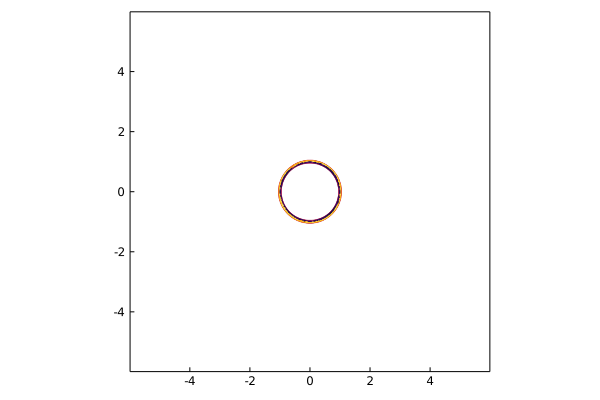

In [7]:
xg, yg = coordinates(w,g)
plot(xg,yg,real(dlayer(1)))

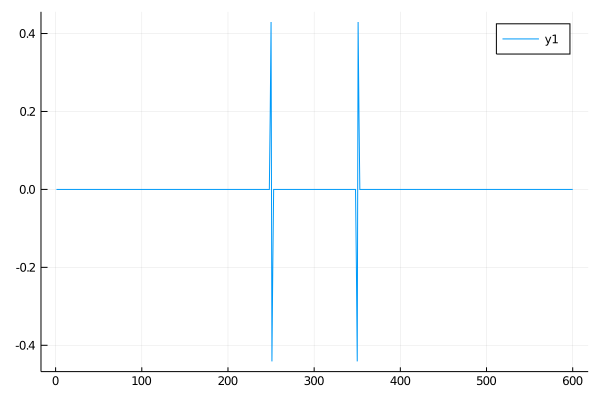

In [8]:
plot(real(dlayer(1))[301,:])

In [9]:
sum(slayer(1))-2π*radius

-0.0009464031059591704 + 0.0im

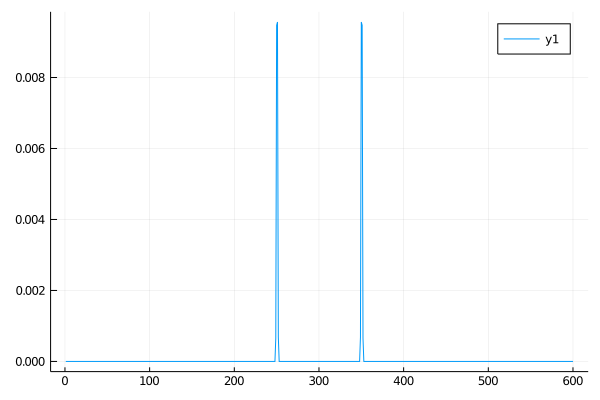

In [10]:
plot(real(slayer(1))[301,:])

In [12]:
inner = Mask(body,regop,w)
outer = ComplementaryMask(inner)

ComplementaryMask{209,600,600,Dual}(Mask{209,600,600,Dual}(Dual nodes in a (nx = 600, ny = 600) cell grid of type Complex{Float64} data
  Number of Dual nodes: (nx = 600, ny = 600)))

In [17]:
w .= 1;

In [19]:
sum(inner(w))*Δx^2 - π

-0.0004741272022750209 + 3.324980141395167e-17im

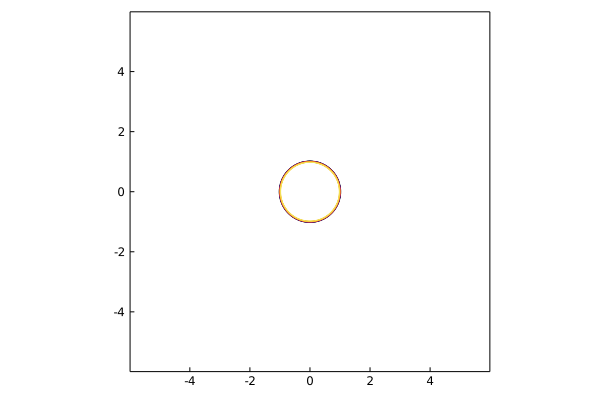

In [20]:
plot(xg,yg,real(inner(w)))

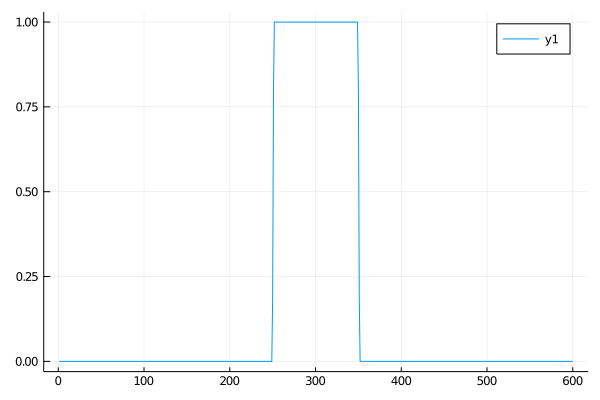

In [21]:
plot(real(inner(w))[:,301])

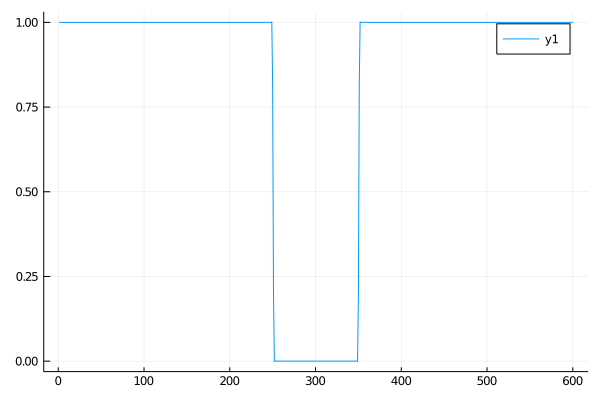

In [22]:
plot(real(outer(w))[301,:])

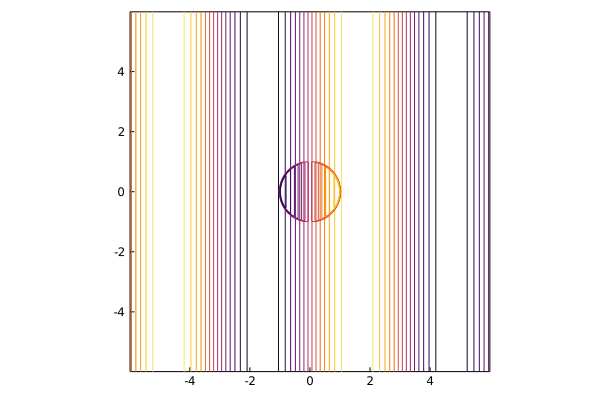

In [24]:
w .= sin.(xg)
plot(xg,yg,real(w))
plot!(xg,yg,real(inner(w)))

### Solution of Laplace's equation

In [40]:
using ConstrainedSystems

┌ Info: Precompiling ConstrainedSystems [c257ce95-4918-4279-a47c-50fdbcb74a04]
└ @ Base loading.jl:1260


In [84]:
Δx = 0.01
xlim = (-2,2)
ylim = (-2,2)
g = PhysicalGrid(xlim,ylim,Δx)

w = Nodes(Primal,size(g));
q = Edges(Primal,w);

In [155]:
radius = 0.5
k = 1.0
body = Circle(radius,k*Δx)
X = VectorData(collect(body))
f = VectorData(X,dtype=Float64)
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true,ddftype=CartesianGrids.Yang3)

ds = areas(body)
nrm = normals(body);

In [156]:
us⁻ = ScalarData(exp.(body.x).*cos.(body.y));
us⁺ = ScalarData(X);
ūs = 0.5*(us⁺ + us⁻)
Δus = k*(us⁺ - us⁻);

In [157]:
u = Nodes(Primal,size(g),dtype=Float64);
q = Edges(Primal,size(g),dtype=Float64);

In [158]:
Rf, Ef = RegularizationMatrix(regop,f,q);

In [159]:
Rc, Ec = RegularizationMatrix(regop,ūs,u);

In [160]:
w = -divergence(Rf*(Δus ∘ nrm));

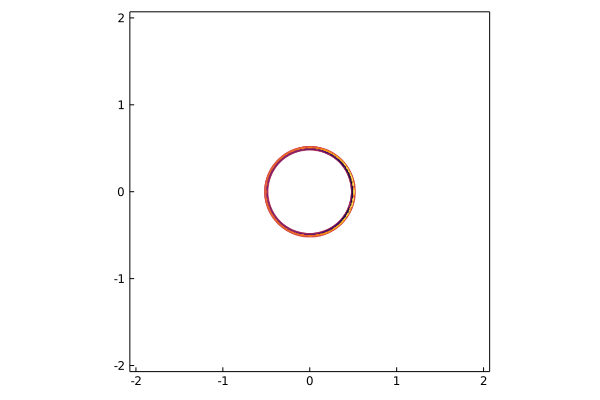

In [161]:
plot(w,g)

In [162]:
L = plan_laplacian(w,with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 415, ny = 415) grid acting on Float64 data with spacing 1.0

In [163]:
rhs = SaddleVector(w,ūs)
PS = SaddleSystem(L,Ec,Rc,rhs);

In [164]:
rhs = SaddleVector(w,ūs);

In [165]:
sol = PS\rhs
ū = state(sol);

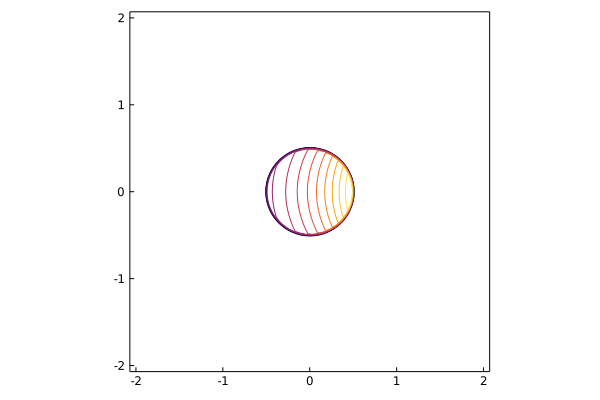

In [166]:
plot(ū,g)

In [167]:
xc, yc = coordinates(w,g);

In [168]:
yc[208]

0.0

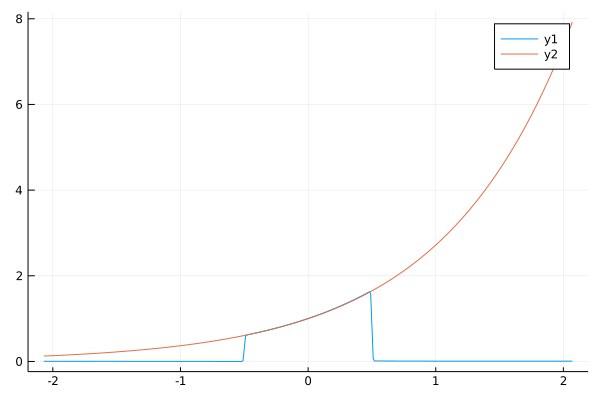

In [169]:
plot(xc,ū[:,208])
plot!(xc,exp.(xc))

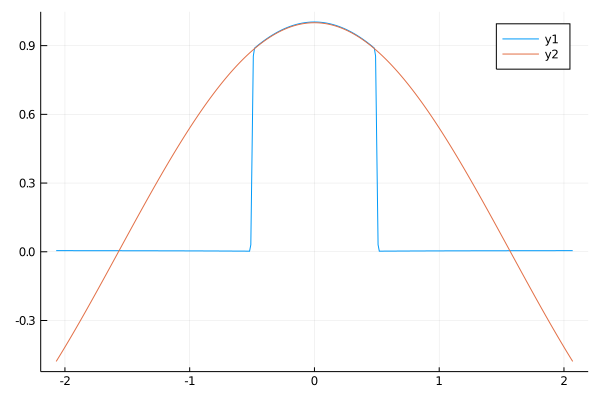

In [170]:
plot(yc,ū[208,:])
plot!(yc,cos.(yc))